In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns; sns.set()
#os.environ["PROJ_LIB"] = "D:\Anaconda\Library\share";
from mpl_toolkits.basemap import Basemap
import cmocean
from scipy.stats import gaussian_kde
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split as ttt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import make_interp_spline
import warnings
warnings.filterwarnings('ignore')

### Analysis of Szeged's Weather From 2006 to 2016
#### In this notebook, we will try to answer the following questions, and possibly more while exploring our data:
##### Is there a relationship between humidity and temperature? 
##### What about between humidity and apparent temperature? 
##### Can you predict the apparent temperature?

Let's take a look at Szeged's location on the map!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


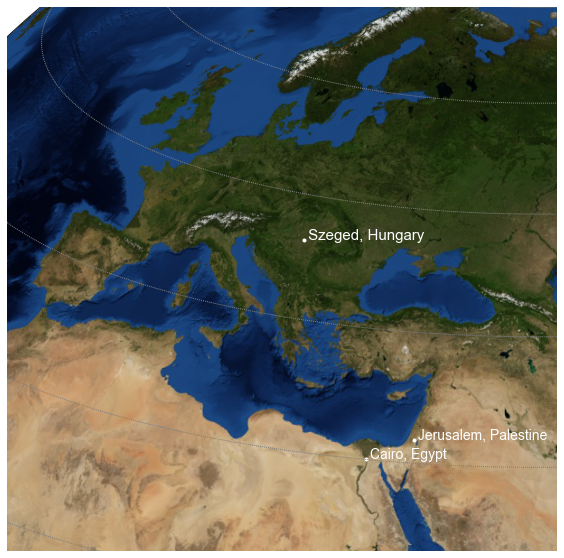

In [2]:
fig = plt.figure(figsize=(10,10))
e = Basemap(projection = 'ortho', lon_0 = 46.2530, lat_0 = 20.1414)
e.bluemarble(scale = 1)
xmin, ymin = e(0 , 18)
xmax, ymax = e(50 ,  70)
x,y = e(20.1482400,46.2530000)
x2,y2 = e(31.238806493183326, 30.042502787732285)
x3,y3 = e(35.2357523470417, 31.77852737475595)
plt.plot(x, y, 'ow', markersize=3)
plt.text(x, y, ' Szeged, Hungary', fontsize=15, color = 'white');
plt.plot(x2, y2, 'ow', markersize=3)
plt.text(x2, y2, ' Cairo, Egypt', fontsize=14, color = 'white');
plt.plot(x3, y3, 'ow', markersize=3)
plt.text(x3, y3, ' Jerusalem, Palestine', fontsize=14, color = 'white');
ax = plt.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
parallels = np.arange(0.,81,10.)
# labels = [left,right,top,bottom]
e.drawparallels(parallels,labels=[False,True,True,False], linewidth = 1, color = 'grey')
plt.show()

Off the top of our heads, Szeged lies in Hungary, a green European country far from the equator. 

This should make us expect a colder, rainier weather to be the daily norm for Hunagrian citizens.

In [3]:
#reading data from csv file
data = pd.read_csv('weatherHistory.csv')

In [4]:
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


Uncertain about the meaning or the importance of "Loud Cover" , and the data being all zeroes, we will drop it

There's an error in the data however, it's possible for wind bearing to be 0 degrees, meaing winds are coming directly from the North, even visbility can go as low as 0 because of very dense fogs or smoke. 

<b>What cannot be 0 however is the pressure, which is a certain error in the data otherwise citizens of Szeged enjoyed a perfect vaccum for a day or more!</b>

In [5]:
#Drop "Loud Cover"
data.drop("Loud Cover" , axis = 1,inplace = True)
#To not lose an entire row the data where 0 pressure is observed, we will infer the data with the data from the previous hour
data['Pressure (millibars)'].replace(0,np.nan, inplace =True)
data.fillna(method = 'pad',inplace = True)
data['Pressure (millibars)'].describe()

count    96453.000000
mean      1016.817525
std          7.779863
min        973.780000
25%       1012.120000
50%       1016.560000
75%       1021.170000
max       1046.380000
Name: Pressure (millibars), dtype: float64

In [6]:
#removing timezone part of the the Formatted Date column, setting it as the index for our data
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'].apply(lambda x: x.split('+')[0]) )
data = data.set_index('Formatted Date')     
data = data.sort_index()

Text(0.5, 0, 'Year')

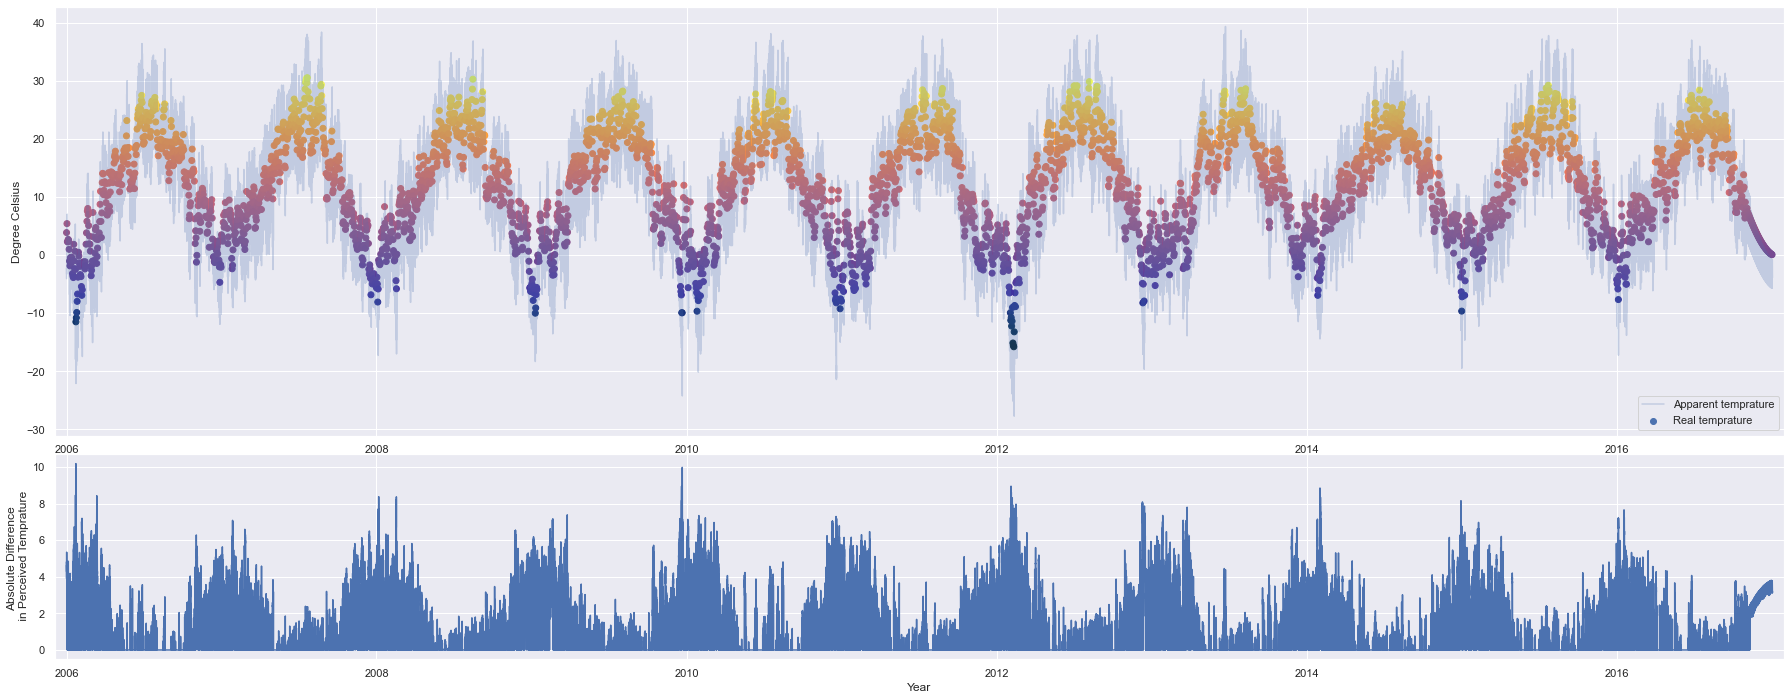

In [7]:
plt.figure(figsize = (31,12))
grid = plt.GridSpec(6,1)
ax = plt.subplot(grid[:4,:])
byday = data.resample('d', base = 0).mean()
ax.scatter(byday.index,byday['Temperature (C)'],c = byday['Temperature (C)'] ,cmap = cmocean.cm.thermal, label = 'Real temprature')
ax.margins(x=0.007)
ax.plot(data.index,data['Apparent Temperature (C)'], alpha = 0.25, label = 'Apparent temprature')
ax.legend(loc = 'lower right')
ax.set_ylabel(ylabel = 'Degree Celsius')
data['Variation'] = data['Temperature (C)'] - data['Apparent Temperature (C)']
data['Variation'] = np.abs(data['Variation'])
ax2 = plt.subplot(grid[4:,0])
ax2.plot(data.index, data['Variation'])
ax2.margins(x=0.007)
ax2.set_ylabel('Absolute Difference \n in Perceived Temprature')
ax2.set_xlabel(xlabel = 'Year')

From the top figure in the subplots above, we can see that the hottest it got from 2006 - 2016 in Szeged is around 31°C, and the coldest it got was at the beginning of 2012 reaching around -16°C which also seems to be it's coldest year in this dataset.

Szeged's apparent temprature varies the most around the extremes, it seems. Is this truly the case or is it just more apparent on the edges of peaks and minimums of the scatter plot? 

The bottom figure answers this, showing  that perceived temprature is significantly larger in colder *actual* tempratures. But why is this the case? 

What's special about colder days that makes the apparent temprature so low?




A piece by Jose Luis Valls García, Veterinarian, Poultry Adviser - via aviNews says:

_Apparent temperature is the reaction of living beings to the set of ambient conditions determining climate from a thermal point of view. We often say that it is hot or cold, according to what a normal thermometer says, however not only temperature (dry air temperature) determines the “real feel” of a human being, but other parameters are likewise involved which may improve or worsen the real feel or apparent temperature._

- Most influential factors are ambient relative humidity and air velocity.

Source: https://avicultura.info/en/importance-of-apparent-temperature/

Text(0.5, 0, 'Month')

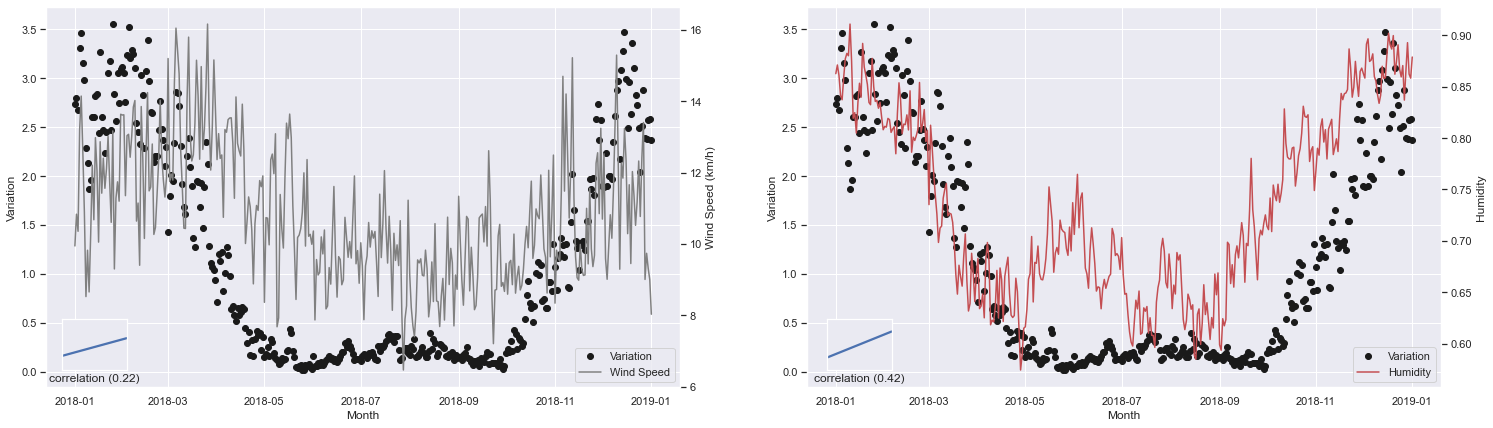

In [8]:
fakedate =  pd.date_range(start='1/1/2018', end = '1/1/2019' ,freq='d')
avgyear = data.groupby([data.index.month, data.index.day]).mean()

def r2(x, y):
    return pearsonr(x, y)[0] 

fig, ax= plt.subplots(1,2, figsize = (25,7))
ax[0].plot(fakedate,avgyear['Variation'],'ok', label = 'Variation' )
ax[0].set_ylabel('Variation')
e = ax[0].twinx()
e.grid(None)
e.plot(fakedate,avgyear['Wind Speed (km/h)'].values,'gray' , label = 'Wind Speed')
e.set_ylabel('Wind Speed (km/h)')
lines = ax[0].get_lines() + e.get_lines()
plt.legend([lines[i] for i in [0,1]],['Variation','Wind Speed'],loc = 'lower right')

t = plt.axes([0.559,0.16,0.0357,0.1])
sns.regplot(data.Variation, data['Wind Speed (km/h)'], scatter_kws={'alpha' : 0},ax = t).set(ylim=(0.5, 35) ,xticks = [],yticks=[],ylabel = None , xlabel = 'correlation ({:.2f})'.format(r2(data.Variation, data['Wind Speed (km/h)'])))
ax[0].set_xlabel(xlabel = 'Month')

ax[1].plot(fakedate,avgyear['Variation'],'ok', label = 'Variation' )
ax[1].set_ylabel('Variation')
e = ax[1].twinx()
e.grid(None)
e.plot(fakedate,avgyear['Humidity'].values,c= 'r' , label = 'Humidity')
lines = ax[1].get_lines() + e.get_lines()
plt.legend([lines[i] for i in [0,1]],['Variation','Humidity'],loc = 'lower right')

e.set_ylabel('Humidity')
a = plt.axes([0.134,0.16,0.0357,0.1])
sns.regplot(data.Variation, data.Humidity, scatter_kws={ 'alpha' : 0}, ax = a).set(ylim=(0.5, 1.25) ,xticks = [],yticks=[],ylabel = None , xlabel = 'correlation ({:.2f})'.format(r2(data.Variation, data.Humidity)))
ax[1].set_xlabel(xlabel = 'Month')

Our data confirms the statement ,Variation has a positive correlation with Humidity and wind speed; meaning as Variation increases they both increase on average!

Days with higher variation are usually more windy or humid. Days are usually more humid and windier in colder months, probably due to precipitation and storms making the average person feel a lot colder.

Let's take a look on the pressure's effect on a the weather

Pressure seems to be normally distributed with a low amount of variance, it's std being 7.78 of it mean value 1016.82
Probably not enough for an average person to notice, but might help predict other factors about the weather!


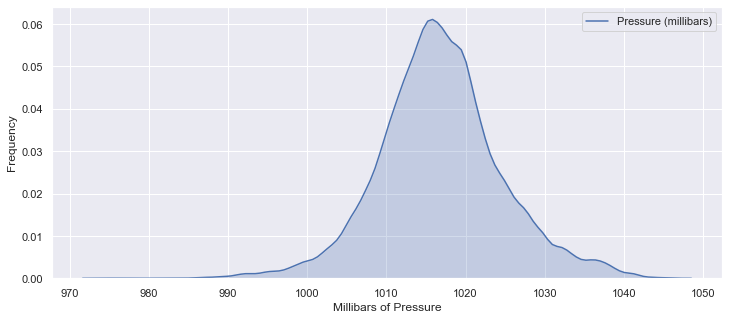

In [9]:
plt.figure(figsize = (12,5))
sns.kdeplot(data['Pressure (millibars)'], shade = True)
plt.gca().set_ylabel('Frequency')
plt.gca().set_xlabel('Millibars of Pressure')
print("Pressure seems to be normally distributed with a low amount of variance, it's std being {:.2f} of it mean value {:.2f}".format(data['Pressure (millibars)'].std(), data['Pressure (millibars)'].mean()))
print('Probably not enough for an average person to notice, but might help predict other factors about the weather!')

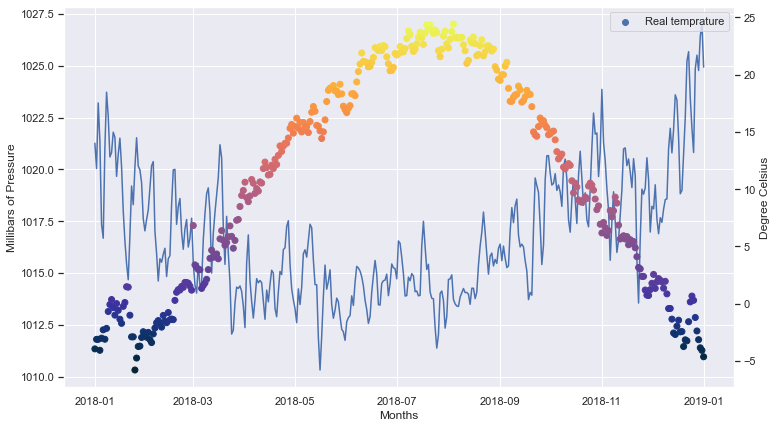

In [10]:
plt.figure(figsize = (12,7))
plt.plot(fakedate, avgyear['Pressure (millibars)'].values, label = 'Real temprature')
plt.gca().set_xlabel('Months')
plt.gca().set_ylabel('Millibars of Pressure')
othery = plt.gca().twinx()
othery.set_ylabel('Degree Celsius')
plt.gca().grid(None)
othery.scatter(fakedate,avgyear['Apparent Temperature (C)'].values,c = avgyear['Apparent Temperature (C)'], cmap = cmocean.cm.thermal, label = 'Real temprature')
plt.legend()


Temprature appears to inversely proportionate with real temprature.. This shouldn't be the case in controlled conditions in a closed system, where pressure rises with temprature, but when this takes effect in the atmosphere, it's not as simple.

_"Meteorologists gather barometric readings and represent them on weather maps with “H” and “L” to indicate areas of high and low pressure. Very cold temperatures can create areas of high air pressure because cold air has greater density and the concentration of molecules can raise the air pressure. ...  A low-pressure system, L, is an area of less dense air with warmer air temperatures. "
Mentzer, A.P.. "How Does Temperature Affect Barometric Pressure?" sciencing.com, https://sciencing.com/temperature-affect-barometric-pressure-5013070.html. 12 August 2021._

The figure plotted confirms the article quoted.

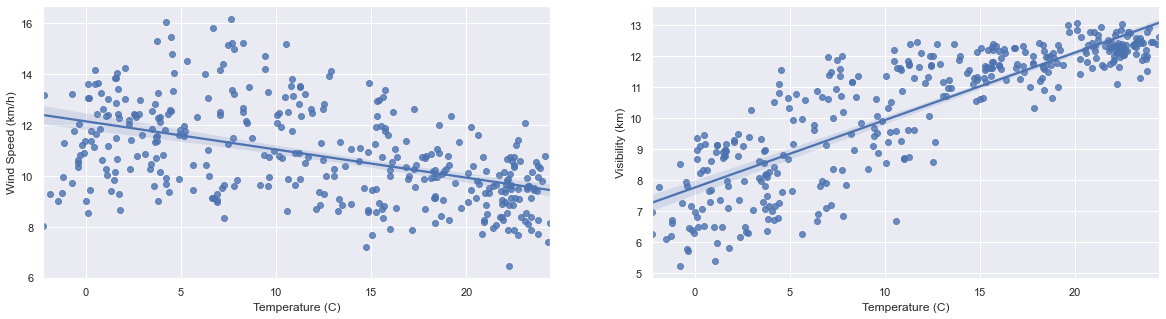

In [11]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.regplot( 'Temperature (C)','Wind Speed (km/h)',avgyear, ax = ax[0])
sns.regplot( 'Temperature (C)','Visibility (km)',avgyear, ax = ax[1])

A few other interesting, yet expected observations are that visibility increases with the increase in temprature, due to the summer having clearer skies and less fog and that wind speed is less in the summer relative to winter.

## Now we will try to answer the prediction question, can we predict the apparent temprature to a human being from the real temprature and other variables that affect it?

In [12]:
data

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Variation
Formatted Date,,,,,,,,,,,
2006-01-01 00:00:00,Partly Cloudy,rain,0.577778,-4.050000,0.89,17.1143,140.0,9.9820,1016.66,Mostly cloudy throughout the day.,4.627778
2006-01-01 01:00:00,Mostly Cloudy,rain,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,1016.15,Mostly cloudy throughout the day.,4.400000
2006-01-01 02:00:00,Mostly Cloudy,rain,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,1015.87,Mostly cloudy throughout the day.,4.822222
2006-01-01 03:00:00,Overcast,rain,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,1015.56,Mostly cloudy throughout the day.,3.905556
2006-01-01 04:00:00,Mostly Cloudy,rain,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,1014.98,Mostly cloudy throughout the day.,3.927778
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,Mostly Cloudy,rain,0.488889,-2.644444,0.86,9.7566,167.0,8.0178,1020.03,Mostly cloudy throughout the day.,3.133333
2016-12-31 20:00:00,Mostly Cloudy,rain,0.072222,-3.050000,0.88,9.4185,169.0,7.2450,1020.27,Mostly cloudy throughout the day.,3.122222
2016-12-31 21:00:00,Mostly Cloudy,snow,-0.233333,-3.377778,0.89,9.2736,175.0,9.5795,1020.50,Mostly cloudy throughout the day.,3.144444


The Summary column is a lot simpler so we're going to drop the Daily Summary and opt to use just that for our prediction model.

In [13]:
data.drop(['Daily Summary'], axis = 1, inplace = True)

Let's vectorize the "Summary" and the "Precip Type" columns

In [14]:
vectorizer = CountVectorizer()
vectorizer2 = CountVectorizer()
X = vectorizer.fit_transform(data.Summary.values)
X2 = vectorizer2.fit_transform(data['Precip Type'].values)
arr = X.toarray()
arr2 = X.toarray()
for no, label in enumerate(vectorizer.get_feature_names()):
    data[label] = arr[:,no]
for no, label in enumerate(vectorizer2.get_feature_names()):
    data[label] = arr2[:,no]

In [15]:
data.drop(['Summary', 'Precip Type', 'Variation','and'], axis = 1, inplace =True)
#We dropped the variation column since that's basically the answer to our question to the model as well as "and" as it's a stopword with no intuitive meaning

Our data should now be all numeric

In [16]:
data

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),breezy,clear,cloudy,...,dry,foggy,humid,light,mostly,overcast,partly,rain,windy,snow
Formatted Date,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,0.577778,-4.050000,0.89,17.1143,140.0,9.9820,1016.66,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2006-01-01 01:00:00,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,1016.15,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2006-01-01 02:00:00,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,1015.87,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2006-01-01 03:00:00,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,1015.56,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2006-01-01 04:00:00,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,1014.98,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0.488889,-2.644444,0.86,9.7566,167.0,8.0178,1020.03,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2016-12-31 20:00:00,0.072222,-3.050000,0.88,9.4185,169.0,7.2450,1020.27,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2016-12-31 21:00:00,-0.233333,-3.377778,0.89,9.2736,175.0,9.5795,1020.50,0,0,1,...,0,0,0,0,1,0,0,0,0,0


We'll try to predict the apparent temprature with a linear model after after splitting our data into training and testing sets.

In [17]:
xtrain, xtest , ytrain, ytest = ttt(data.drop('Apparent Temperature (C)', axis = 1) , data['Apparent Temperature (C)'])

print('X training shape =',  xtrain.shape, 'X test shape =',  xtest.shape, '\n', 'Y training shape =' , ytrain.shape, 'Y test shape ='  ,ytest.shape)

X training shape = (72339, 21) X test shape = (24114, 21) 
 Y training shape = (72339,) Y test shape = (24114,)


Our training and testing sets are in shapes that make sense, now we will find out through a grid search which  linear regression characteristics yield the best results in predicting apparent temprature

In [18]:
param_grid = {
    'fit_intercept':[True,False],
    'normalize':[True,False]
}
grid = GridSearchCV(LinearRegression(),param_grid,cv = 10)
grid.fit(xtrain,ytrain.values.reshape(-1,1))
grid.best_params_

{'fit_intercept': True, 'normalize': False}

Using the parameters we computed, we try to predict the xtest data

In [19]:
model = LinearRegression(fit_intercept = True)
model.fit(xtrain,ytrain)
predicted= model.predict(xtest)

In [20]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(ytest,predicted)
print(f'R2 value of {r_value**2:.2f} with a p-value of {p_value:.2f}' )

R2 value of 0.99 with a p-value of 0.00


### We get an R2 score of 99%, meaning that our data explains 99% of the variation of apparent weather from real weather! 
### with a P-value of 0%, meaning our R2 is definitely statistically significant

In [21]:
params = pd.Series(model.coef_, index=xtrain.columns)
params

Temperature (C)           1.131708
Humidity                  1.158061
Wind Speed (km/h)        -0.097809
Wind Bearing (degrees)    0.000571
Visibility (km)           0.008914
Pressure (millibars)      0.014635
breezy                   -0.155752
clear                    -0.234391
cloudy                   -0.082730
dangerously              -0.014427
drizzle                   0.176262
dry                      -1.626121
foggy                     0.052237
humid                    -1.306574
light                     0.149935
mostly                    0.028676
overcast                 -0.163497
partly                   -0.111407
rain                      0.987074
windy                     0.619499
snow                     -0.155752
dtype: float64

### Reading the above coeffecients of every column of our training dataset in this linear regression task, it seems like the variables with the words humid, wind, dry or snow in the name have the highest effect on the output. Which makes sense as our exploration of the data proved most of those are very correlated with apparent temprature.